In [ ]:
!pip uninstall torch -y


Found existing installation: torch 2.0.1
Uninstalling torch-2.0.1:
  Successfully uninstalled torch-2.0.1


In [ ]:
!pip install torch==2.0.1+cu117 -f https://download.pytorch.org/whl/cu117/torch_stable.html


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in links: https://download.pytorch.org/whl/cu117/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 87.4 MB/s eta 0:00:0000:0100:01


In [1]:
import torch
print(torch.__version__)           # PyTorch Version: 2.4.1
print(torch.cuda.is_available())   # CUDA Availability: False

2.0.1+cu117
True


In [1]:
# Data processing
import numpy as np
import pandas as pd
import math as m
import datetime as dt
import torch
import os

# Results presentation
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
os.makedirs("Data/", exist_ok=True)

In [3]:
data = pd.read_csv('earthquakes_data.csv', sep=',')

In [4]:
data[0::70000]

,year,month,date,hour,minute,seconds,lat,long,depth,class
0,1990,1,1,2,19,5.018,42.2734,144.8460,8.0,2.9
70000,2000,6,6,21,27,8.060,36.8930,135.4800,10.0,4.0
140000,2007,4,10,1,22,24.013,38.9598,141.6975,73.7,4.0
210000,2012,3,21,17,47,45.055,40.8428,144.8634,35.0,3.7


In [5]:
ORIGIN_LATITUDE  = 27.0
ORIGIN_LONGITUDE = 127.0
EARTH_RADIUS     = 6373.0

def spherical_to_cartesian (longitude, latitude):
    X = (longitude - ORIGIN_LONGITUDE) * m.pi / 180 * EARTH_RADIUS * m.cos (latitude * m.pi / 180)
    Y = (latitude  - ORIGIN_LATITUDE ) * m.pi / 180 * EARTH_RADIUS

    return X, Y

In [6]:
XY_massive = np.zeros((data.shape[0], 2))
j = 0
for i in tqdm(range (XY_massive.shape[0])):
    XY_massive[i][0], XY_massive[i][1] = spherical_to_cartesian (data['long'][i], data['lat'][i])

data['x'] = XY_massive[:, 0]
data['y'] = XY_massive[:, 1]

/tmp/ipykernel_15958/2882637354.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range (XY_massive.shape[0])):


  0%|          | 0/247474 [00:00<?, ?it/s]

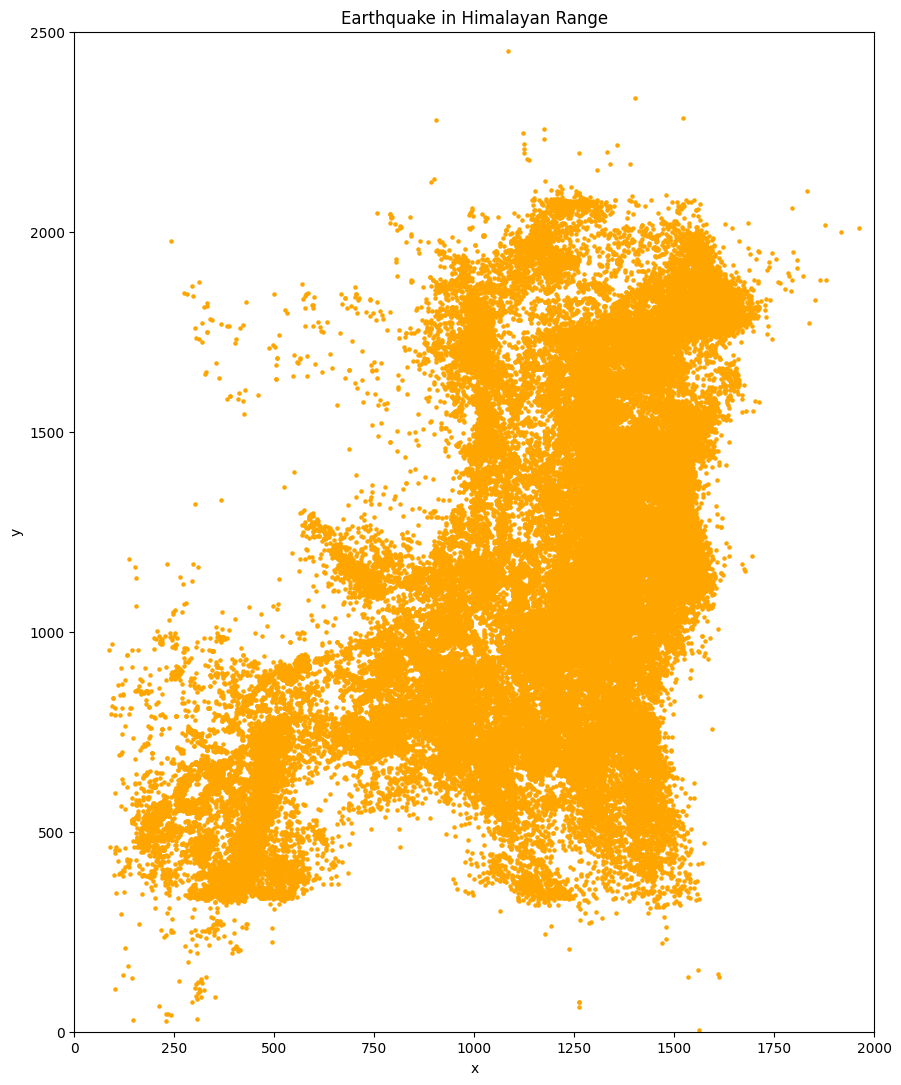

In [7]:

fig = plt.figure(figsize=(10, 12.5))

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

axes.scatter(data['x'], data['y'], color='orange', marker='.', s=20)
plt.axis([0, 2000, 0, 2500])

axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_title('Earthquake in Himalayan Range')

plt.show()

In [8]:
time_massive = np.zeros (data.shape[0])

d_0 = dt.date (data['year'][0], data['month'][0], data['date'][0])
for i in tqdm(range (data.shape[0])):
    d_i = dt.date (data['year'][i], data['month'][i], data['date'][i])
    time_massive[i] = (d_i - d_0).days

data['time'] = time_massive

/tmp/ipykernel_15958/565386800.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range (data.shape[0])):


  0%|          | 0/247474 [00:00<?, ?it/s]

In [9]:
data = pd.read_csv('old.csv', sep=',')

In [10]:
LEFT_BORDER = -1200
RIGHT_BORDER = 0
DOWN_BORDER = -300
UP_BORDER = 700

N_CELLS_HOR = 200
N_CELLS_VER = 250

In [11]:
def create_celled_data(n_cells_hor, n_cells_ver, indicies):
    start_date  = int (data['time'][indicies[0]])
    finish_date = int (data['time'][indicies[-1]])
    celled_data = torch.zeros ([finish_date - start_date + 1, 1, n_cells_hor, n_cells_ver])

    cell_size_hor = (RIGHT_BORDER - LEFT_BORDER) / n_cells_hor
    cell_size_ver = (UP_BORDER    - DOWN_BORDER) / n_cells_ver

    for i in tqdm(indicies):
        if ((data['x'][i] > LEFT_BORDER)  and
            (data['x'][i] < RIGHT_BORDER) and
            (data['y'][i] > DOWN_BORDER)  and
            (data['y'][i] < UP_BORDER)):

            x = int (data['x'][i] / cell_size_hor)
            y = int (data['y'][i] / cell_size_ver)
            celled_data[int(data['time'][i]) - start_date, 0, x, y] = data['mag'][i]
    print (celled_data.shape)
    return celled_data

In [12]:
celled_data = create_celled_data(N_CELLS_HOR, N_CELLS_VER, range (data.shape[0]))


/tmp/ipykernel_15958/3614267874.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(indicies):


  0%|          | 0/2588 [00:00<?, ?it/s]

torch.Size([42223, 1, 200, 250])


In [13]:
print(celled_data)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [14]:
print(celled_data.shape)
print(celled_data.min())
print(celled_data.max())
print(torch.sum(celled_data != 0))

# # Check if any earthquakes were assigned to cells
if torch.sum(celled_data != 0) == 0:
    print("No earthquakes were assigned to cells. Please check your data and grid setup.")


torch.Size([42223, 1, 200, 250])
tensor(0.)
tensor(7.9000)
tensor(2428)


In [15]:
freq_map = (celled_data>0).float().mean(dim=0)

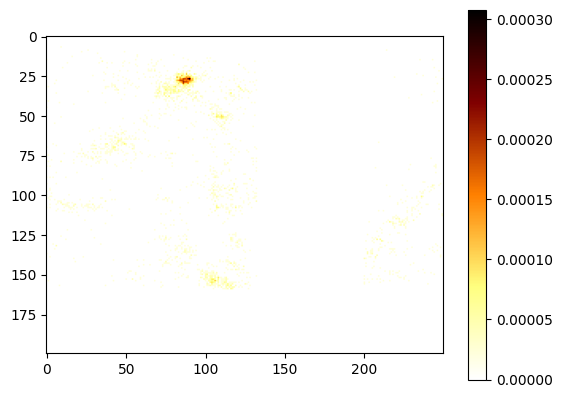

In [16]:
plt.imshow (freq_map.squeeze(0), cmap=plt.cm.afmhot_r)
plt.colorbar()

In [10]:
torch.save(celled_data,
           "celled_data_" +
           str(N_CELLS_HOR) +
           "x" +
           str(N_CELLS_VER))

torch.save(freq_map,
           "freq_map_" +
           str(N_CELLS_HOR) +
           "x" +
           str(N_CELLS_VER))


Training_loop


In [17]:
# System
import os

# Data processing
import numpy as np

# Results presentation
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

# NN related stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

# All hyperparameters are listed in model.py you can change them there
import train
from model import *

%matplotlib inline

In [18]:
N_CELLS_HOR = 200
N_CELLS_VER = 250

In [19]:
celled_data = torch.load("celled_data_"
                         + str(N_CELLS_HOR)
                         + "x"
                         + str(N_CELLS_VER))
print (celled_data.shape)

torch.Size([42223, 1, 200, 250])


In [20]:
DEVICE_ID = 0
torch.cuda.set_device(DEVICE_ID)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print (DEVICE)

cuda


In [21]:
OBSERVED_DAYS = 30      
DAYS_TO_PREDICT_AFTER = 5
DAYS_TO_PREDICT_BEFORE = 20
TESTING_DAYS = 1000      

HEAVY_QUAKE_THRES = 3.5 


In [22]:
freq_map = (celled_data>HEAVY_QUAKE_THRES).float().mean(dim=0)


In [23]:
class Dataset_RNN_Train (Dataset):
    def __init__(self, celled_data):
        self.data = celled_data[0:
                                (celled_data.shape[0] -
                                 TESTING_DAYS)]
        self.size = (self.data.shape[0] -
                     DAYS_TO_PREDICT_BEFORE)

        print ('self.data :', self.data.shape)
        print ('size      :', self.size)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return (self.data[idx],
                torch.sum(self.data[(idx +
                                     DAYS_TO_PREDICT_AFTER):
                                    (idx +
                                     DAYS_TO_PREDICT_BEFORE)] > HEAVY_QUAKE_THRES,
                          dim=0,
                          keepdim=True).squeeze(0) > 0)


In [24]:
dataset_train = Dataset_RNN_Train (celled_data)

dataloader_train = DataLoader(dataset_train,
                              batch_size=1,
                              shuffle=False,
                              num_workers=1)

self.data : torch.Size([41223, 1, 200, 250])
size      : 41203


In [25]:
N_CYCLES = 5           
QUEUE_LENGHT = 20       
LEARNING_RATE = 0.001   
LR_DECAY = 5.0          
EARTHQUAKE_WEIGHT = 5000 

Done : 41200 / 41203


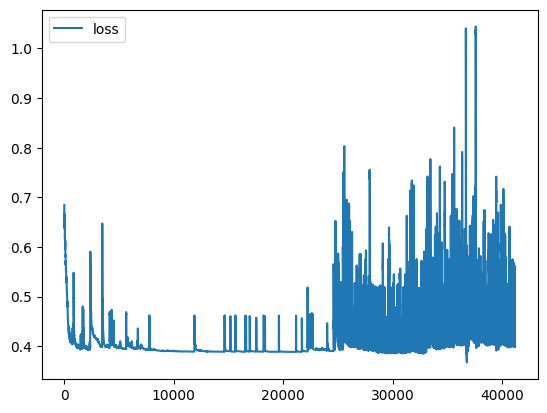

In [26]:
RNN_cell = LSTMCell(freq_map,
                    embedding_size    = EMB_SIZE,
                    hidden_state_size = HID_SIZE,
                    n_cells_hor       = N_CELLS_HOR,
                    n_cells_ver       = N_CELLS_VER,
                    device            = DEVICE)

train.train_RNN_full (RNN_cell,
                      DEVICE,
                      dataloader_train,
                      n_cycles=1,
                      learning_rate=LEARNING_RATE,
                      earthquake_weight=EARTHQUAKE_WEIGHT,
                      lr_decay=LR_DECAY)

In [27]:
if not os.path.exists("Model"):
    os.mkdir("Model")
torch.save(RNN_cell.state_dict(), "Model/state_dict")

Estimating_quality


In [28]:
# System
import os

# Data processing
import numpy as np

# Results presentation
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm  # Updated import

import matplotlib.pyplot as plt

# NN related stuff
import torch
from torch.utils.data import Dataset, DataLoader

# Metrics
from sklearn.metrics import accuracy_score#
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

%matplotlib inline

In [29]:
DEVICE_ID = 0
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(DEVICE_ID)
print (DEVICE)

cuda


In [30]:
N_CELLS_HOR = 200
N_CELLS_VER = 250

In [31]:
celled_data = torch.load("celled_data_"
                         + str(N_CELLS_HOR)
                         + "x"
                         + str(N_CELLS_VER))
print (celled_data.shape)

torch.Size([42223, 1, 200, 250])


In [32]:
OBSERVED_DAYS = 30      
DAYS_TO_PREDICT_AFTER = 5
DAYS_TO_PREDICT_BEFORE = 20
TESTING_DAYS = 1000     

HEAVY_QUAKE_THRES = 3.5 


In [33]:
freq_map = (celled_data>HEAVY_QUAKE_THRES).float().mean(dim=0)


In [34]:
class Dataset_RNN_Test (Dataset):
    def __init__(self, celled_data):
        self.data = celled_data[(celled_data.shape[0] -
                                 TESTING_DAYS):
                                (celled_data.shape[0])]
        self.size = (self.data.shape[0] -
                     DAYS_TO_PREDICT_BEFORE)

        print ('self.data :', self.data.shape)
        print ('size      :', self.size)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return (self.data[(idx)],
                torch.sum(self.data[(idx +
                                     DAYS_TO_PREDICT_AFTER):
                                    (idx +
                                     DAYS_TO_PREDICT_BEFORE)] > HEAVY_QUAKE_THRES,
                          dim=0,
                          keepdim=True).squeeze(0) > 0)

In [35]:
dataset_test  = Dataset_RNN_Test(celled_data)

dataloader_test  = DataLoader(dataset_test,
                              batch_size=1,
                              shuffle=False,
                              num_workers=1)

self.data : torch.Size([1000, 1, 200, 250])
size      : 980


In [36]:
from model import *

In [37]:
RNN_cell = LSTMCell(freq_map,
                    embedding_size    = EMB_SIZE,
                    hidden_state_size = HID_SIZE,
                    n_cells_hor       = N_CELLS_HOR,
                    n_cells_ver       = N_CELLS_VER,
                    device            = DEVICE)

RNN_cell.load_state_dict(torch.load("Model/state_dict"))
_ = RNN_cell.eval()

In [38]:
def my_precision_TPR_FPR (input, target, threshold):
    TP = torch.sum ((  (input>threshold) .float() * target      ).float())
    FP = torch.sum ((  (input>threshold) .float() * (1 - target)).float())
    FN = torch.sum (((~(input>threshold)).float() * target      ).float())
    TN = torch.sum (((~(input>threshold)).float() * (1 - target)).float())
    return TP / (TP + FP), TP / (TP + FN), FP / (FP + TN)

def check_quality (RNN_cell,
                   device,
                   dataloader_test,
                   n_dots=501,
                   info_file=None):

    prediction = torch.zeros(dataloader_test.__len__(),  N_CELLS_HOR, N_CELLS_VER,
                             device=device,
                             dtype=torch.float)
    prediction.detach_()
    target     = torch.zeros(dataloader_test.__len__(), N_CELLS_HOR, N_CELLS_VER,
                             device=device,
                             dtype=torch.float)
    target.detach_()

    RNN_cell.to(device)

    hid_state = RNN_cell.init_state(batch_size=1, device=device)
    if (type(hid_state) == tuple):
        for elem in hid_state:
            elem.detach_()
    else:
        hid_state.detach_()

    i = 0
    for data in tqdm(dataloader_test):

        inputs = data[0].to(device)
        labels = data[1].to(device).float()

        hid_state, outputs = RNN_cell.forward(inputs, hid_state)

        prediction[i] = outputs[:, 1, :, :]
        target    [i] = labels.squeeze(0)

        if (type(hid_state) == tuple):
            for elem in hid_state:
                elem.detach_()
        else:
            hid_state.detach_()
        prediction.detach_()
        target    .detach_()
        i += 1

    assert prediction.shape == target.shape
    prediction = prediction [10:prediction.shape[0]]  # cutting peace of data because
    target     = target     [10:target    .shape[0]]  # hidden state might be not good

    print ("ROC_AUC_score = ", end='')
    ROC_AUC_score = roc_auc_score(np.array(target    .view(-1).cpu()),
                                  np.array(prediction.view(-1).cpu()))
    print (ROC_AUC_score)

    print ("AVG_precision_score = ", end='')
    AVG_precision_score = average_precision_score(np.array(target    .view(-1).cpu()),
                                                  np.array(prediction.view(-1).cpu()))
    print (AVG_precision_score)

    threshold_massive = torch.linspace (0, 1, n_dots, dtype=torch.float, device=device)

    precision_massive = []
    recall_massive    = []
    FPR_massive       = []

    for threshold in tqdm(threshold_massive):
        precision, recall, FPR = my_precision_TPR_FPR(prediction, target, threshold)
        precision_massive.append(precision.item())
        recall_massive   .append(recall.item())
        FPR_massive      .append(FPR.item())

    # plot 1 precision
    fig = plt.figure(figsize=(10, 6))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(np.array(threshold_massive.cpu()), precision_massive, color='green', marker='.')

    axes.set_xlabel('threshold')
    axes.set_ylabel('precision')

    plt.show()

    # plot 2 recall
    fig = plt.figure(figsize=(10, 6))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(np.array(threshold_massive.cpu()), recall_massive, color='green', marker='.')

    axes.set_xlabel('threshold')
    axes.set_ylabel('recall')

    plt.show()

    # plot 3 ROC-curve
    fig = plt.figure(figsize=(8, 8))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(FPR_massive, recall_massive, 'orange', marker = '.')
    axes.plot (range(2), range(2), 'grey', ls='--')

    axes.set_xlabel('FPR')
    axes.set_ylabel('TPR (recall)')
    axes.set_title('ROC-curve')

    plt.show()

    # plot 4 precision-recall-curve
    fig = plt.figure(figsize=(8, 8))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(recall_massive, precision_massive, 'orange', marker = '.')

    axes.set_xlabel('Recall')
    axes.set_ylabel('Precision')
    axes.set_title('Precision_Recall_curve')

    plt.show()

    return ROC_AUC_score, AVG_precision_score


  0%|          | 0/980 [00:00<?, ?it/s]

ROC_AUC_score = 0.7956485197573764
AVG_precision_score = 0.00010892871695286242


  0%|          | 0/251 [00:00<?, ?it/s]

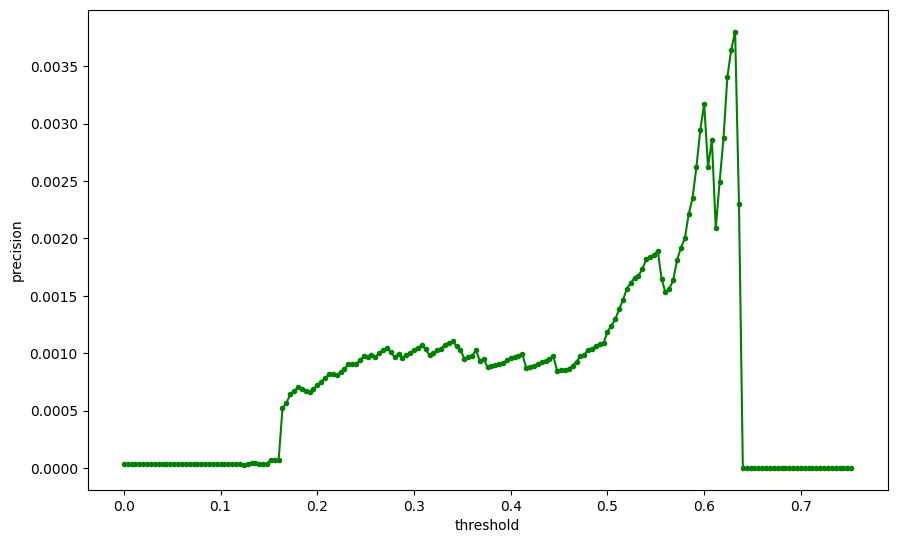

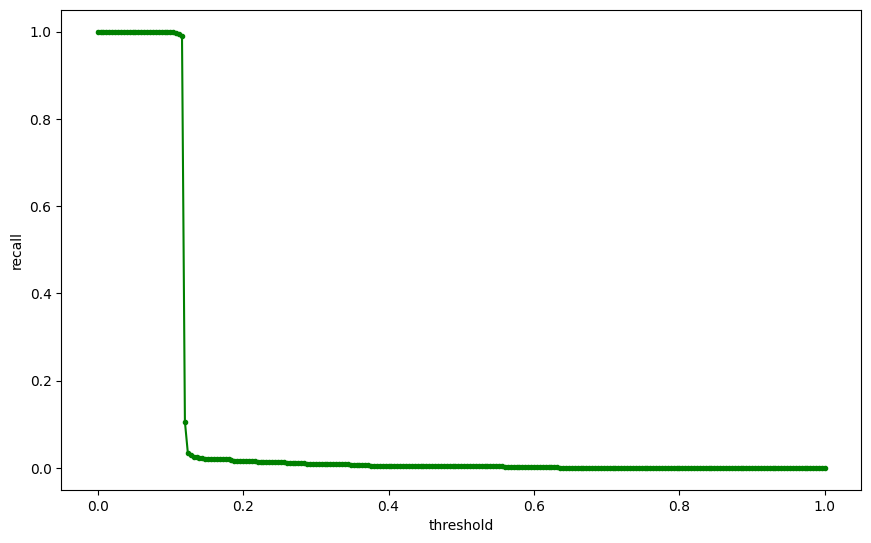

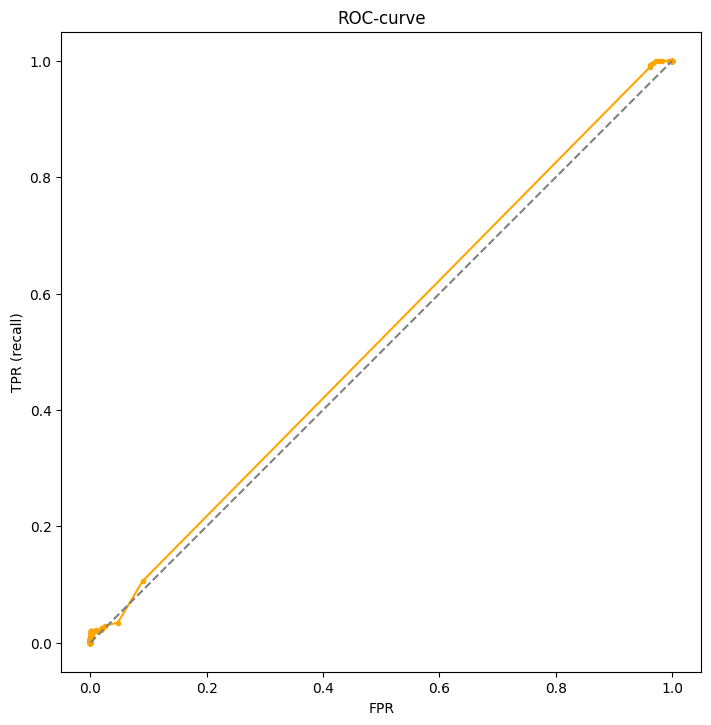

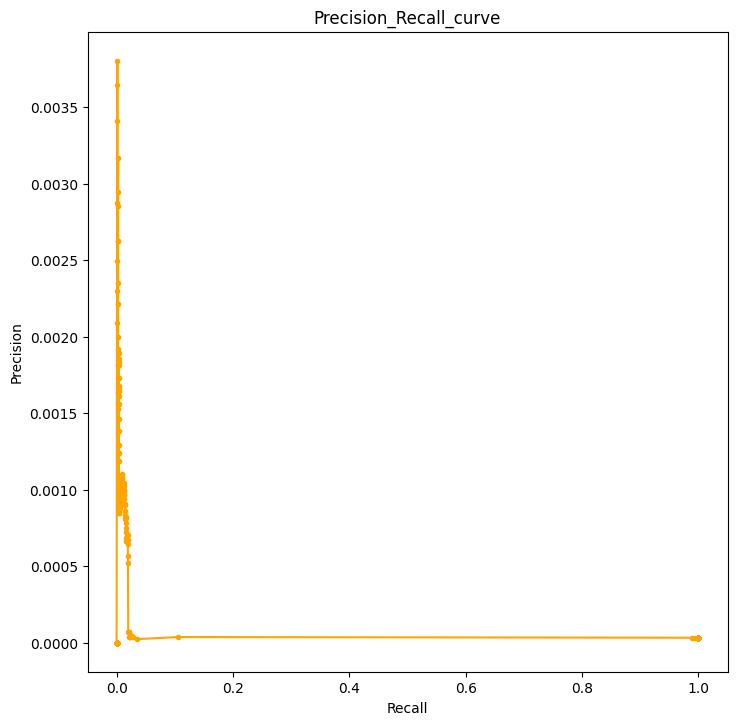

In [39]:
RNN_cell.eval()

ROC_AUC, AVG_prec = check_quality (RNN_cell,
                                   DEVICE,
                                   dataloader_test,
                                   n_dots=251)